# Projeto Final de Ciência de Dados

## Bibliotecas

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, cohen_kappa_score

## Introdução

Nome dos integrantes:

- **Nome**: Alan Teixeira da Costa, **Matrícula**: 2022100831, **E-mail**: alan.costa@edu.ufes.br
- **Nome**: Miguel Vieira Machado Pim, **Matrícula**: 2022100894, **E-mail**: miguel.pim@edu.ufes.br

O objetivo geral deste projeto final é praticar os conceitos estudados durante toda a disciplina de Introdução a Ciência de Dados, principalmente: web scraping e aprendizado supervisionado. Para isso iremos fazer scraping do site https://www.transfermarkt.com.br/ para prever resultados de partidas de futebol a partir de dados da premier league e do brasileirão.

Na primeira entrega do trabalho havíamos falado de usar um conjunto de dados do Kaggle para fazer clusterização de times de futebol, mas decidimos mudar um pouco a ideia com o passar do tempo, pois os conjuntos de dados tinham dados insuficientes para a tarefa que pretendiamos fazer, e também queriamos praticar os conhecimentos sobre aprendizado supervisionado estudados na matéria e, por isso, decidimos coletar dados para fazer nosso próprio conjunto e utilizar classificadores.

## Descrição de Problema

Nosso problema consiste em construir um classificador capaz de prever resultados de partidas de futebol. Este classificador deverá classificar uma partida entre três possíveis resultados: vitória do time da casa, derrota do time da casa ou empate.

## Descrição do Conjunto de Dados

Para este projeto utilizaremos um conjunto de dados de partidas de futebol. Os dados foram obtidos utilizando web scraping para buscar partidas de ligas. O código do scraping pode ser visto no repositório https://github.com/Alan-TC/Scraper-T2-CienciaDeDados. Vale ressaltar que utilizamos apenas os dados de partidas de ligas desse repositório.

Os dados estão organizados em um arquivo (```partidas.csv```) com as seguintes colunas:  

Colunas com informações sobre a partida, indepedente do time:  
- **capacidade_estadio**: Capacidade do estádio do time da casa (```int```)
- **publico_estadio**: Público total que compareceu ao jogo (```int```)
- **ano**: Ano em que o jogo aconteceu (```int```)
- **fase**: Rodada da liga em que o jogo aconteceu (```str```)  

Colunas com informações sobre os times. No arquivo, para cada coluna com "casa" no nome também existe uma coluna com "fora" no nome, que foram omitidas por terem características iguais:
- **time_casa**: Nome do time da casa (```str```)
- **valor_mercado_casa**: Soma total do valor de mercado dos jogadores do time da casa (```float```)
- **valor_mercado_media_casa**: Valor médio de mercado dos jogadores do time da casa (```float```)
- **media_idade_casa**: Média de idade dos jogadores do time da casa (```float```)
- **jogadores_de_selecao_casa**: Quantidade de jogadores convocados para alguma seleção principal do time da casa (```float```)
- **jogadores_de_sub_selecao_casa**: Quantidade de jogadores convocados para alguma seleção que não principal, por exemplo, sub-20 do time da casa (```float```)
- **estrangeiros_casa**: Quantidade de jogadores estrangeiros do time da casa (```float```)
- **gols_casa**: Quantidade de gols do time da casa (```int```)
- **posse_casa**: Quantidade de posse de bola do time da casa em porcentagem (```int```)
- **socios_torcedores_casa**: Quantidade de sócio torcedores do time da casa (```float```)
- **tentativas_casa**: Quantidade de chutes do time da casa (```int```)
- **chutes_fora_casa**: Quantidade de chutes pra fora do gol da casa (```int```)
- **defesa_casa**: Quantidade de defesas do goleiro do time da casa (```int```)
- **escanteios_casa**: Quantidade de escanteios do time da casa (```int```)
- **cobrancas_falta_casa**: Quantidade de cobranças de falta do time da casa (```int```)
- **faltas_cometidas_casa**: Quantidade de faltas cometidas pelo time da casa (```int```)
- **impedimentos_casa**: Quantidade de impedimentos do time da casa (```int```)

Portanto, no total temos 38 colunas do nosso dataframe.

In [2]:
partidas_df = pd.read_csv("partidas.csv")
partidas_df.head()

,capacidade_estadio,publico_estadio,time_casa,valor_mercado_casa,valor_mercado_media_casa,media_idade_casa,jogadores_de_selecao_casa,jogadores_de_sub_selecao_casa,estrangeiros_casa,gols_casa,...,posse_fora,tentativas_fora,chutes_fora_fora,defesa_fora,escanteios_fora,cobrancas_falta_fora,faltas_cometidas_fora,impedimentos_fora,ano,fase
0,50848,0,SC Internacional,97050.0,2370.0,25.3,4.0,3.0,9.0,2,...,47,9,3,6,3,19,13,2,2024,1.Rodada
1,19225,0,Criciúma EC,12150.0,347.0,25.2,0.0,0.0,0.0,1,...,53,15,7,2,4,9,15,4,2024,1.Rodada
2,82238,0,Fluminense FC,66750.0,1850.0,28.2,6.0,2.0,9.0,2,...,31,16,7,9,6,8,19,0,2024,1.Rodada
3,72039,0,São Paulo FC,76850.0,2260.0,27.0,7.0,0.0,7.0,1,...,29,6,3,4,4,10,14,1,2024,1.Rodada
4,24584,0,CR Vasco da Gama,84750.0,2290.0,27.5,3.0,2.0,12.0,2,...,53,9,5,1,5,18,10,1,2024,1.Rodada


## Metodologia

Para atingir o objetivo proposto utilizaremos os seguintes passos:  

- Fazer scraping de dados do site https://www.transfermarkt.com.br/.
- Pré-processamento dos dados (retirar colunas desnecessárias dos dados e adicionar a coluna com as labels).
- Aplicação de ao menos três algoritmos de aprendizado supervisionado vistos em aula.
- Validação da metodologia utilizada.
- Interpretação dos resultados.

## Pré-processamento

### Adicionando coluna label

Os valores dos labels serão:  

- **Vitoria**: Vitória do time da casa
- **Empate**: Empate
- **Derrota**: Derrota do time da casa

In [3]:
def add_label_column(row):
    if (row["gols_casa"] > row["gols_fora"]):
        return 'Vitoria'
    elif (row["gols_casa"] < row["gols_fora"]):
        return 'Derrota'
    else:
        return 'Empate'

In [4]:
partidas_df["label"] = partidas_df.apply(add_label_column, axis=1)
partidas_df[["gols_casa", "gols_fora", "label"]].head()

,gols_casa,gols_fora,label
0,2,1,Vitoria
1,1,1,Empate
2,2,2,Empate
3,1,2,Derrota
4,2,1,Vitoria


### Transformando coluna da fase

In [5]:
partidas_df["fase"] = list(map(lambda x : int(x.split('.')[0]), partidas_df["fase"]))
partidas_df["fase"].head()

0    1
1    1
2    1
3    1
4    1
Name: fase, dtype: int64

### Retirando colunas desnecessárias

Tirando os nomes dos times e a quantidade de gols dos times.  

A quantidade de gols dos times foi retirada, pois seria como se estivéssemos dando o gabarito para o algoritmo. O RandomForestClassifier, por exemplo, teve um acerto de $100\%$ quando passamos para ele o dataframe com as quantidades de gols.

In [6]:
partidas_df.drop(columns=["time_casa", "time_fora", "gols_casa", "gols_fora"], inplace=True)
partidas_df.head()

,capacidade_estadio,publico_estadio,valor_mercado_casa,valor_mercado_media_casa,media_idade_casa,jogadores_de_selecao_casa,jogadores_de_sub_selecao_casa,estrangeiros_casa,posse_casa,socios_torcedores_casa,...,tentativas_fora,chutes_fora_fora,defesa_fora,escanteios_fora,cobrancas_falta_fora,faltas_cometidas_fora,impedimentos_fora,ano,fase,label
0,50848,0,97050.0,2370.0,25.3,4.0,3.0,9.0,53,142000.0,...,9,3,6,3,19,13,2,2024,1,Vitoria
1,19225,0,12150.0,347.0,25.2,0.0,0.0,0.0,47,18000.0,...,15,7,2,4,9,15,4,2024,1,Empate
2,82238,0,66750.0,1850.0,28.2,6.0,2.0,9.0,69,48280.0,...,16,7,9,6,8,19,0,2024,1,Empate
3,72039,0,76850.0,2260.0,27.0,7.0,0.0,7.0,71,151724.0,...,6,3,4,4,10,14,1,2024,1,Derrota
4,24584,0,84750.0,2290.0,27.5,3.0,2.0,12.0,47,53957.0,...,9,5,1,5,18,10,1,2024,1,Vitoria


### Verificando a proporção de vitória, derrota e empate para o time da casa

<Axes: xlabel='label', ylabel='Count'>

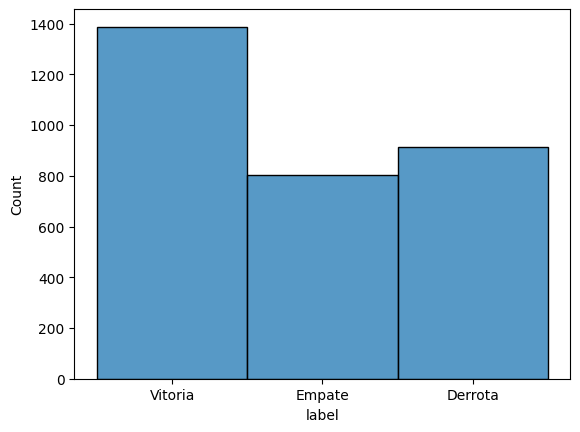

In [7]:
sns.histplot(partidas_df['label'])

Observa-se que existe uma proporção bem maior de vitórias do que empates e derrotas.

## Aplicando algoritmos de classificação

Separando **partidas_df** em x e y

In [8]:
y = partidas_df["label"]
X = partidas_df.drop(columns=["label"])

Separando os dados em treino e teste

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

### KNN

#### Escolha do $K$

In [10]:
k_range = range(1, 50)
k_scores = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors = k)
    scaler = preprocessing.MinMaxScaler(feature_range = (0, 10))
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring='accuracy')
    k_scores.append(scores.mean())

Text(0, 0.5, 'Acurácia do KNN')

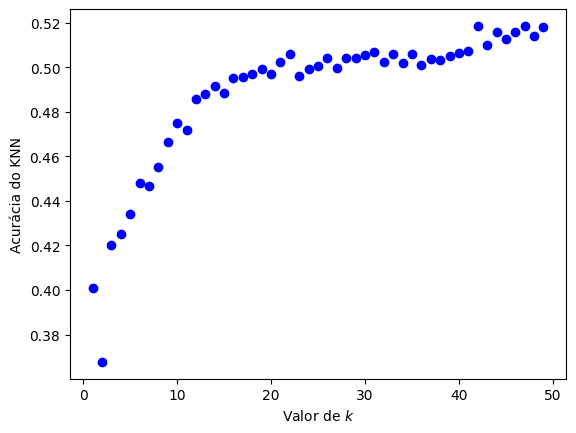

In [11]:
plt.scatter(k_range, k_scores, color = 'blue')
plt.xlabel(r'Valor de $k$')
plt.ylabel('Acurácia do KNN')

A partir desse gráfico podemos definir que um bom valor é $k = 39$, pois nas proximidades desse ponto o aumento do valor de $k$ não impacta significativamente na acurácia.

#### Normalizando - Definindo o scaler

In [12]:
scaler = preprocessing.MinMaxScaler(feature_range = (0, 10))
scaler.fit(X_train)

MinMaxScaler(feature_range=(0, 10))

#### Realizando o treinamento

In [13]:
k = 39
model = KNeighborsClassifier(n_neighbors = k)
X_train_scaled = scaler.transform(X_train)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=39)

#### Obtendo predição do conjunto de teste

In [14]:
X_test_scaled = scaler.transform(X_test)
y_pred_knn = model.predict(X_test_scaled)

### Floresta aleatória

#### Escolhendo hiperparâmetros

Definindo um acervo de parâmetros para que o ```GridSearchCV``` ache a melhor combinação.

In [15]:
params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 1.0],
    'max_samples': [0.2, 0.6, 1.0]
}

In [43]:
grid_search_random_forest = GridSearchCV(RandomForestClassifier(),
                           param_grid=params, cv=5, n_jobs=-1, verbose=9)

In [44]:
grid_search_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_depth=2, max_features=sqrt, max_samples=0.2, n_estimators=100;, score=0.474 total time=   0.3s
[CV 4/5] END max_depth=2, max_features=sqrt, max_samples=0.2, n_estimators=100;, score=0.454 total time=   0.3s
[CV 2/5] END max_depth=2, max_features=sqrt, max_samples=0.2, n_estimators=100;, score=0.508 total time=   0.3s
[CV 3/5] END max_depth=2, max_features=sqrt, max_samples=0.2, n_estimators=100;, score=0.471 total time=   0.4s
[CV 2/5] END max_depth=2, max_features=sqrt, max_samples=0.6, n_estimators=100;, score=0.501 total time=   0.4s
[CV 5/5] END max_depth=2, max_features=sqrt, max_samples=0.2, n_estimators=100;, score=0.470 total time=   0.4s
[CV 3/5] END max_depth=2, max_features=sqrt, max_samples=0.6, n_estimators=100;, score=0.474 total time=   0.4s
[CV 4/5] END max_depth=2, max_features=sqrt, max_samples=0.6, n_estimators=100;, score=0.465 total time=   0.4s
[CV 5/5] END max_depth=2, max_features=sq

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'max_samples': [0.2, 0.6, 1.0],
                         'n_estimators': [100, 500, 1000]},
             verbose=9)

In [45]:
grid_search_random_forest.best_params_

{'max_depth': 6, 'max_features': 1.0, 'max_samples': 0.2, 'n_estimators': 1000}

Realizando as predições do classificador.

In [46]:
y_pred_random_forest = grid_search_random_forest.predict(X_test)

### SVM

#### Escolhendo hiperparâmetros

Definindo um acervo de parâmetros para que o ```GridSearchCV``` ache a melhor combinação.

In [20]:
tuned_parameters = {
    "kernel": ["rbf", "linear"],
    "gamma": [0.01, 0.001, 0.0001],
    "C": [1, 10, 100, 1000]
}

In [21]:
grid_search = GridSearchCV(SVC(probability=True), cv=5, param_grid=tuned_parameters, n_jobs=-1, verbose=9)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.555 total time=   2.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.548 total time=   2.1s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.560 total time=   2.1s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.552 total time=   2.1s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.552 total time=   2.2s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.513 total time=   2.2s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.536 total time=   2.3s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.552 total time=   2.3s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.533 total time=   2.4s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.569 total time=   2.6s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.485 total time=   2.2s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=9)

In [22]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}

Realizando as predições do classificador.

In [23]:
y_pred_svm = grid_search.predict(X_test_scaled)

## Resultados

### Matriz de confusão, acuracy, precision, recall e f1-score

#### KNN

In [24]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

     Derrota       0.43      0.44      0.44       266
      Empate       0.34      0.11      0.16       240
     Vitoria       0.55      0.75      0.64       426

    accuracy                           0.50       932
   macro avg       0.44      0.44      0.41       932
weighted avg       0.46      0.50      0.46       932



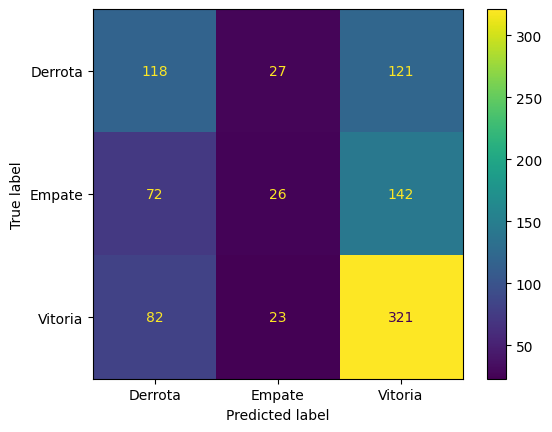

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)

#### Floresta aleatória

In [26]:
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

     Derrota       0.52      0.45      0.48       266
      Empate       0.32      0.07      0.12       240
     Vitoria       0.57      0.86      0.68       426

    accuracy                           0.54       932
   macro avg       0.47      0.46      0.43       932
weighted avg       0.49      0.54      0.48       932



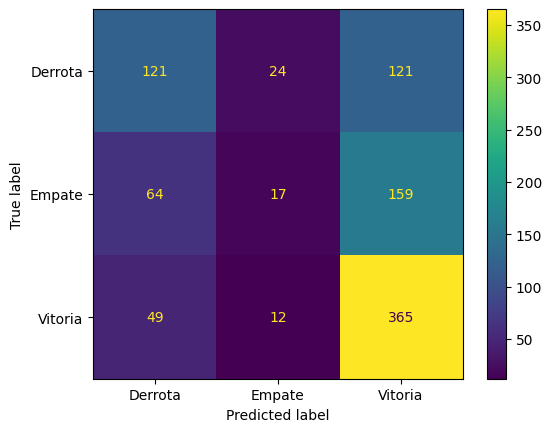

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_random_forest)

#### SVM

In [28]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

     Derrota       0.54      0.57      0.56       266
      Empate       0.32      0.14      0.19       240
     Vitoria       0.62      0.80      0.70       426

    accuracy                           0.56       932
   macro avg       0.50      0.50      0.48       932
weighted avg       0.52      0.56      0.53       932



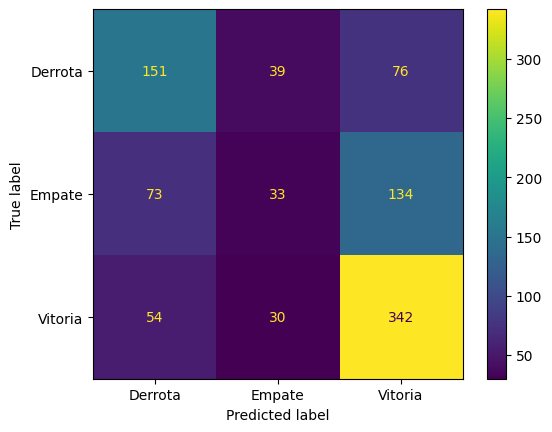

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)

### Curvas ROC e métrica AUC

In [30]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

#### KNN

In [31]:
y_proba_knn = model.predict_proba(X_test_scaled)
y_proba_knn

array([[0.66666667, 0.20512821, 0.12820513],
       [0.17948718, 0.15384615, 0.66666667],
       [0.17948718, 0.33333333, 0.48717949],
       ...,
       [0.51282051, 0.20512821, 0.28205128],
       [0.53846154, 0.17948718, 0.28205128],
       [0.46153846, 0.30769231, 0.23076923]], shape=(932, 3))

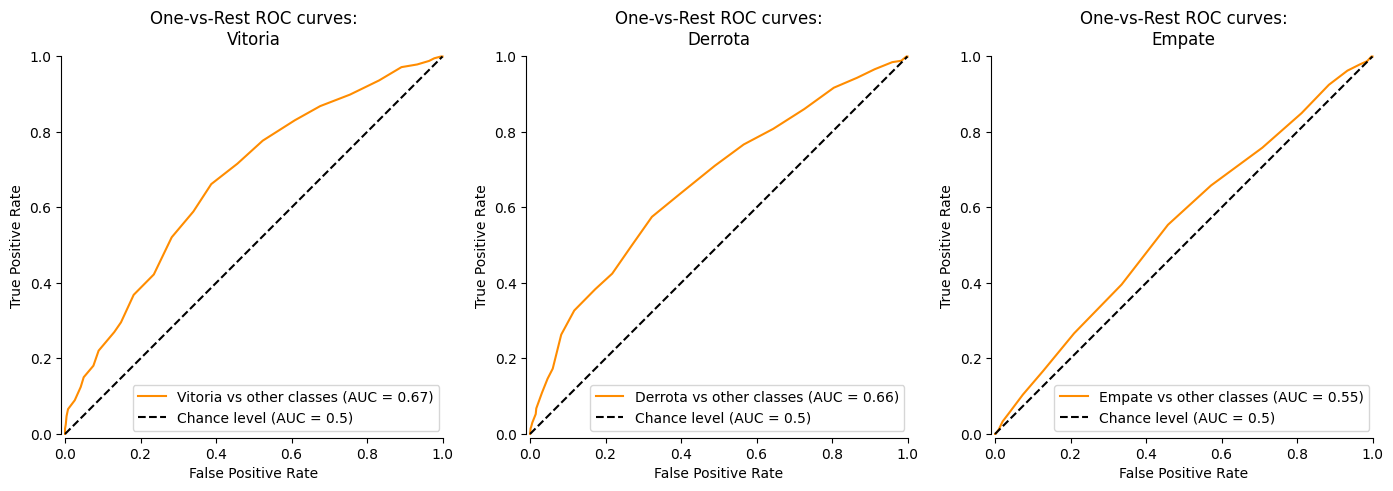

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, class_of_interest in zip(axes, ["Vitoria", "Derrota", "Empate"]):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_id

    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_proba_knn[:, class_id],
        name=f"{class_of_interest} vs other classes",
        color="darkorange",
        ax=ax,
        plot_chance_level=True,
        despine=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
    )

#### Floresta Aleatória

In [47]:
y_proba_random_forest = grid_search_random_forest.predict_proba(X_test_scaled)
y_proba_random_forest

/home/miguel/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.29138918, 0.29637508, 0.41223574],
       [0.28138532, 0.2861365 , 0.43247818],
       [0.31305363, 0.31418374, 0.37276263],
       ...,
       [0.29182216, 0.3176305 , 0.39054734],
       [0.30444182, 0.3068598 , 0.38869838],
       [0.31334401, 0.28614454, 0.40051144]], shape=(932, 3))

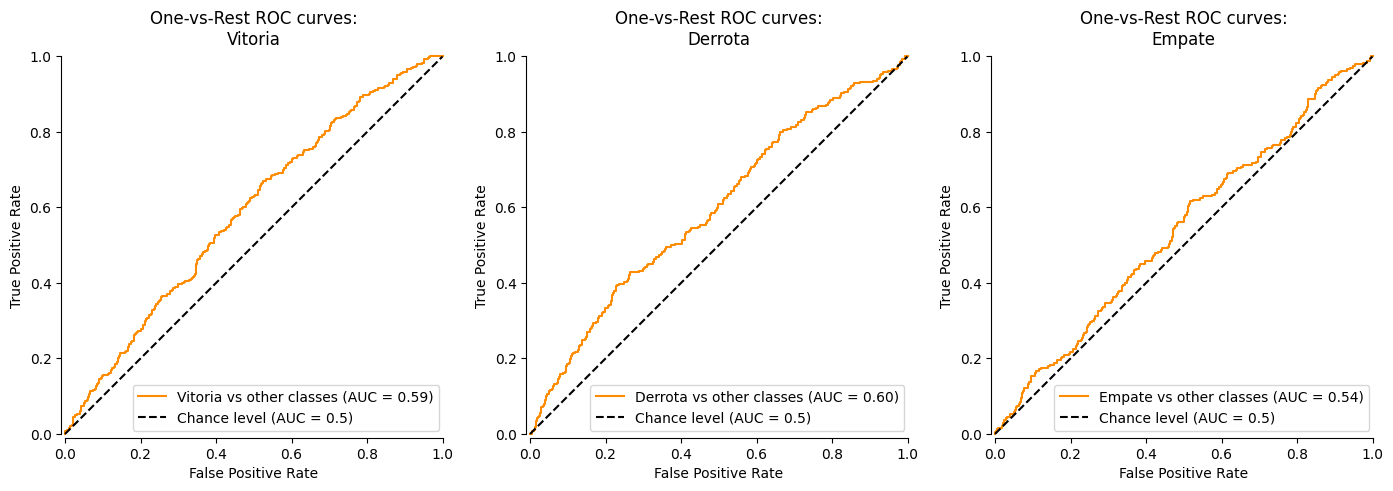

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, class_of_interest in zip(axes, ["Vitoria", "Derrota", "Empate"]):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_id

    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_proba_random_forest[:, class_id],
        name=f"{class_of_interest} vs other classes",
        color="darkorange",
        ax=ax,
        plot_chance_level=True,
        despine=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
    )

#### SVM

In [35]:
y_proba_svm = grid_search.predict_proba(X_test_scaled)
y_proba_svm

array([[0.68129335, 0.23992205, 0.0787846 ],
       [0.10268718, 0.21725925, 0.68005357],
       [0.29453512, 0.37632992, 0.32913496],
       ...,
       [0.81842173, 0.14704221, 0.03453605],
       [0.11026238, 0.26210639, 0.62763123],
       [0.49082289, 0.22467239, 0.28450472]], shape=(932, 3))

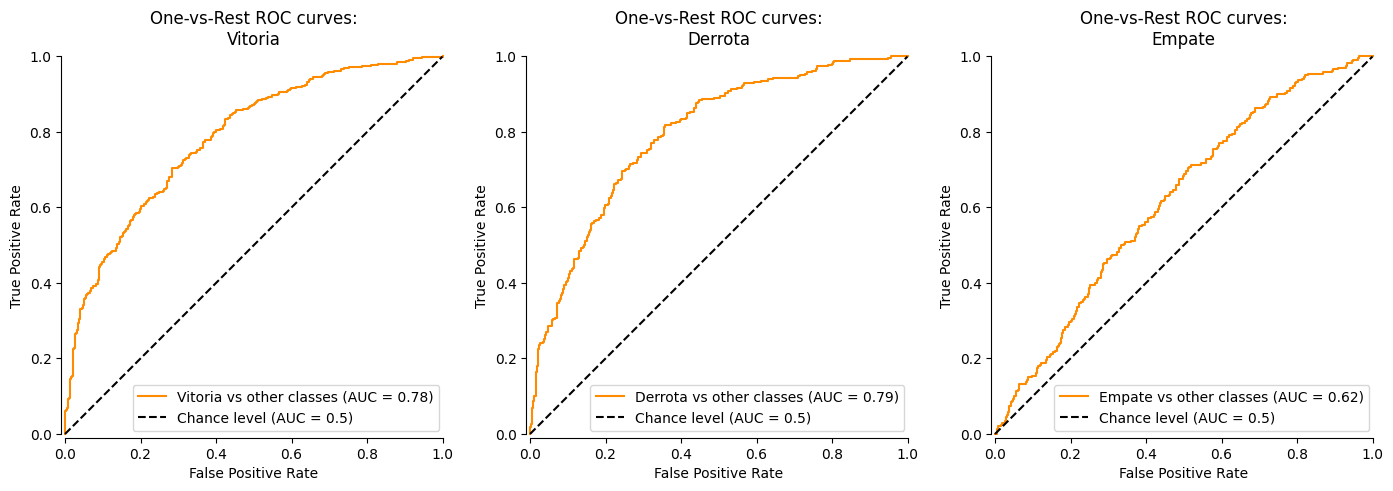

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, class_of_interest in zip(axes, ["Vitoria", "Derrota", "Empate"]):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_id

    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_proba_svm[:, class_id],
        name=f"{class_of_interest} vs other classes",
        color="darkorange",
        ax=ax,
        plot_chance_level=True,
        despine=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{class_of_interest}",
    )

## Conclusões e Discussões

### Validação da Metodologia

1. **Escolha dos hiperparâmetros dos algoritmos**

A escolha dos hiperparâmetros dos algoritmos RandomForest e SVM foram feitas utilizando o ```GridSearchCV```, que a partir de um acervo de possíveis variáveis, ele testa cada uma delas utilizando cross validation.

2. **Impacto da escolha dos algoritmos nos resultados**

Houve um impacto na escolha dos algoritmos, principalmente, ao utilizarmos o SVM que na parte da curva ROC e métricas AUC demonstrou um bom desempenho na previsão de vitórias e derrotas dos times da casa.

### Conclusão final

Os algoritmos não se saíram tão bem como o esperado, mas analisando os resultados percebemos que o SVM por exemplo, teve um desempenho considerável em prever vitórias e derrotas dos times da casa. Percebemos também, que todos os algoritmos foram bem ruins em prever empates, sendo esse o ponto que levou os resultados a não ficarem tão bons.  

Vale lembrar que a quantidade de labels "Vitoria" no dataframe é bem maior do que "Derrota" ou "Empate" e, portanto, isso também influencia os resultados de certa forma.